## Sentiment Analysis with three supervised learning models 
We are going to use a Naive Bayes Classifer, because it is efficient and fast. If time, we will compare it with other methods, especially lexicon & rule-based methods.
The first step of the project is to quickly analyze our data. 

### 1. Exploring the dataset
In this section we will quickly explore the dataset. Namely, we will compute : 
- Ratings and length distributions : 
    - distributon of ratings 
    - distributions of review length in characters and word counts
    - distributions of helpfullness per ratings 
- Wordclouds per ratings (most common words per ratings)

In [1]:
## Requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import nltk as nltk
from nltk import RegexpTokenizer
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, ensemble, svm, metrics, model_selection

In [2]:
#import the csv as a pandas dataframe
file = pd.read_csv('./data/reviews.csv')

In [3]:
#check the features of the dataframe 
for col in file.columns:
    print(col)

Id
ProductId
UserId
ProfileName
HelpfulnessNumerator
HelpfulnessDenominator
Score
Time
Summary
Text


###### Dataframe feature description (as they appear in the df) : 
- Id : row ID (primary key)
- ProductId : Unique identifier for the product
- UserId : Unqiue identifier for the user
- ProfileName : Profile name of the user
- HelpfulnessNumerator : Number of users who found the review helpful
- HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not
- Score : Rating between 1 and 5
- Time : Timestamp for the review
- Summary : Brief summary of the review
- Text : Text of the review

### Ratings and length distributions

In [56]:
# plot the distribution of ratings  
def ratings_distrib(data) :
    """This function plots the distribution of ratings of products [1 to 5].
    It takes as input a pandas dataframe and returns a matplotlib normalized histogram."""
    array = data['Score'].values
    bins = np.arange(1, array.max() + 1.5) - 0.5
    fig, ax = plt.subplots()
    _ = ax.hist(array, bins, rwidth=0.5, density=True)
    ax.set_xticks([1, 2, 3, 4, 5])
    _=plt.xlabel('Rating')
    _=plt.ylabel('Distribution')
    return plt.show()

# plot the distribution of review length
def len_distrib(data):
    """This function plots the distribution of review length in characters. 
    It takes as argument a pandas dataframe and returns a matplotlib histogram."""
    len_str = [len(x) for x in data['Text']]
    _=plt.hist(len_str, density=False, bins = range(0, 4000))
    _=plt.xlabel('Text length in chars')
    _=plt.ylabel('Count')
    return plt.show()

# plot the distribution of word counts, using the nltk RegexpTokenizer
def word_distrib(data):
    """This function plots the distribution of reviews in word counts.
    It takes as argument a pandas dataframe and returns matplotlib histogram."""
    tokenizer = RegexpTokenizer(r'\w+')
    word_counts = [len(tokenizer.tokenize(x)) for x in data['Text']]
    _=plt.hist(word_counts, density=False, bins = range(0, 600))
    _=plt.xlabel('Word Counts')
    _=plt.ylabel('Count')
    return plt.show()


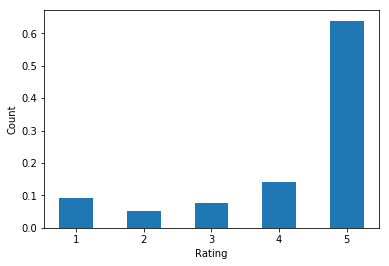

In [53]:
ratings_distrib(file)

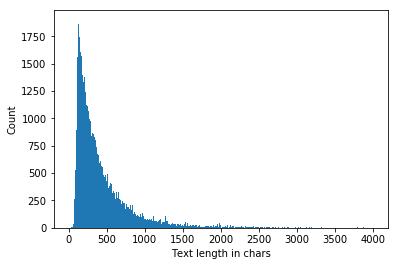

In [54]:
len_distrib(file)

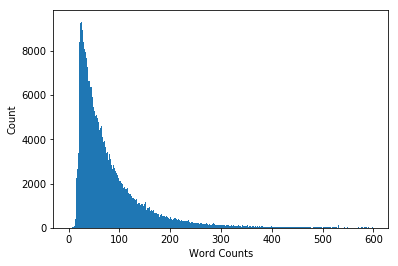

In [55]:
word_distrib(file)

In [88]:
# Plot length distribution of reviews per rating 
def len_rating(file) : 
    """This function plots a boxplot of the legth (in character) distribution per rating.
    It takes as argument a pandas dataframe and returns a matplotlib boxplot."""
    df = pd.DataFrame(file['Text'], file['Score'])
    df['len'] = [len(x) for x in file['Text']]
    fig, ax = plt.subplots(figsize = (25,9))
    df.boxplot(column = ['len'], by = 'Score', ax=ax, showfliers=False) #outliers removed for clarity
    return plt.show()

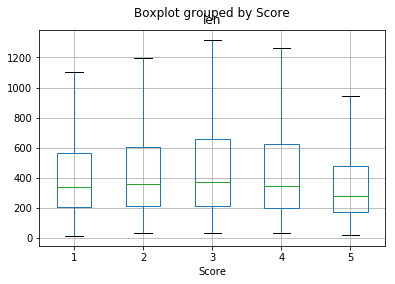

In [89]:
len_rating(file)

In [6]:
# Plot wordcount of reviews per rating
def wordcount_rating(file) : 
    """This function plots the wordcount of reviews per rating.
    It takes as argument a pandas dataframe and returns a matplotlib boxplot."""
    df = pd.DataFrame(file['Text'], file['Score'])
    tokenizer = RegexpTokenizer(r'\w+')
    df['word_counts'] = [len(tokenizer.tokenize(x)) for x in file['Text']]    
    fig, ax = plt.subplots(figsize = (25, 9))
    df.boxplot(column = ['word_counts'], by = 'Score', ax=ax, showfliers=False) #outliers removed for clarity
    return plt.show()

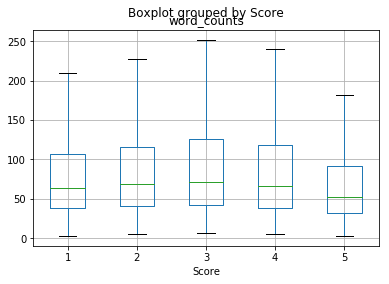

In [7]:
wordcount_rating(file)

/Users/patriciaroze/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


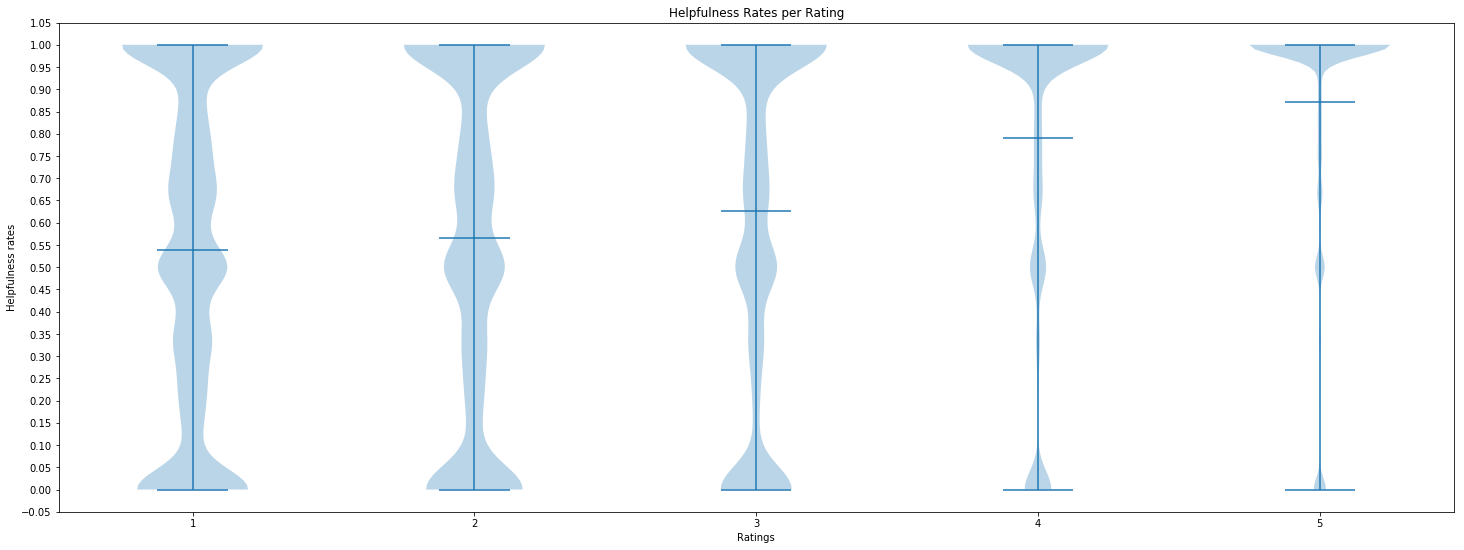

In [150]:
#Plot the distribution of helpfulness score per rating. 
def helpfulness_rating_violin(file):
    """This function plots the distribution of helpfulness score per rating.
    It takes as argument a pandas dataframe and returns a seaborn violin plot."""
    df = file[file['HelpfulnessDenominator']>0]
    df['help_coeff'] = df['HelpfulnessNumerator']/df['HelpfulnessDenominator']
    df = df.drop(df[df['HelpfulnessNumerator']>df['HelpfulnessDenominator']].index)
    fig, axes = plt.subplots(figsize=(25,9))
    axes.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
    axes.violinplot(dataset = [df[df.Score == 1]["help_coeff"].values,
                           df[df.Score == 2]["help_coeff"].values,
                           df[df.Score == 3]["help_coeff"].values,
                           df[df.Score == 4]["help_coeff"].values,
                           df[df.Score == 5]["help_coeff"].values], showmeans = True)
    axes.set_title('Helpfulness Score per Rating')
    axes.set_xlabel('Ratings')
    axes.set_ylabel('Helpfulness rates')
    return plt.show()
helpfulness_rating_violin(file)

### WordClouds per Rating 

In this section, we round up our exploration of the dataset by creating wordclouds from the reviews. We will separate the good and bad reviews. In this first step, we will consider bad reviews as the ones rated from 1 to 2 and the good reviews as the ones rated from 4 to 5. 

In [164]:
#Plot a wordcloud of the most common words within a range of scores.
def wordcloud(file, score_min = 1, score_max = 5) : 
    """This function plots a wordcloud of most common words within a score range.
    It takes as argument a dataframe and returns a wordcloud.
    You can chose the range of scores by indicating a score_min and/or a score_max.
    If you only indicate a min, the function will compute the wordcloud on the range [score_min, 5].
    If you only indicate a score_max, the function will compute the wordcloud on the range [1, score_max]."""
    text = " ".join(review for review in file[(file.Score<=score_max) & (file.Score>=score_min)].Text)
    stopwords = set(STOPWORDS)
    stopwords.update(["br", "gp", 'href'])
    wordcloud = WordCloud(stopwords=stopwords, max_words=500, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    return plt.show()
wordcloud(file, score_min = 4)

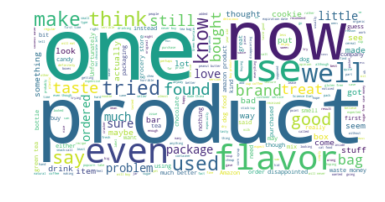

In [165]:
wordcloud(file, score_max = 2)

## 2. Preprocessing
1. Step 1 : Cleaning and Labelization  
    removing empty cells (NaN) 
    bad reviews (rated 1-3) are labeled with 0, good reviews (rated 4-5) are labeled with 1
2. Step 2 : Text preprocessing : Tokenization & Lemmatization

In [72]:
#Clean text, i.e remove nan and lowercase all text and add labels to the reviews.
#Positive reviews (labelled 1) are reviews rated 4 to 5.
#Negative reviews are reviews rated from 1 to 3.
def clean_and_label(data, column1, column2) : 
    """This function cleans and labelizes the dataset.
    It takes as input a pandas dataframe and the column containing the text to clean.
    It returns a pandas dataframe."""
    data2 = data.assign(label = [1]*len(data))
    data2.loc[data2['Score'] <= 3, 'label'] = 0
    data3 = data2.dropna(subset=[column1, column2])
    data3[column1] = data3[column1].apply(lambda x: x.lower())
    data3[column2] =data3[column2].apply(lambda x: x.lower())

    return data3

In [74]:
file2  = clean_and_label(file, 'Summary', 'Text')

/Users/patriciaroze/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/patriciaroze/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [75]:
file2

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,label
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,good quality dog food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,cough medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy,great taffy at a great price. there was a wid...,1
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,nice taffy,i got a wild hair for taffy and ordered this f...,1
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,great! just as good as the expensive brands!,this saltwater taffy had great flavors and was...,1
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"wonderful, tasty taffy",this taffy is so good. it is very soft and ch...,1
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,yay barley,right now i'm mostly just sprouting this so my...,1
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,healthy dog food,this is a very healthy dog food. good for thei...,1


In [76]:
#Tokenize then lemmatize text
def tokenize_and_lem(text):
    """This function converts text into lemmatized tokens.
    It takes as argument a string object of text and returns a list object of lemmatized tokens"""
    lemmatizer = WordNetLemmatizer()
    # Tokenize text by word
    tokens = [sent for sent in nltk.word_tokenize(text)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Lemmatize the filtered_tokens
    lems = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return lems

## 3. Sentiment Analysis on Summaries of reviews 
##### For this step, we will try to predict binary rating from the summaries of reviews. 
#### 1. Vectorize text to analyze
#### 2. Split dataset
#### 3. Instantiate, train and test Model
#### 4. Plot confusion matrix

In [78]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
def instantiate_Tfidf(function) : 
    """This function instantiates the TfidfVectorizer.
    It takes as argument a text preprocessing function and returns a TfidfVectorizer Object."""
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=function,
                                 ngram_range=(1,3))
    return tfidf_vectorizer

In [79]:
tfidf = instantiate_Tfidf(tokenize_and_lem)

In [80]:
#Vectorize the text of the dataset using the TfidfVectorizer
def Tfidf_vectorize(tfidf_vectorizer, series):
    """This function vectorizes the text of the dataset using the TfidfVectorizer.
    It takes as argument a TfidfVectorizer object and Series object and returns an array object of vectors."""
    features = tfidf_vectorizer.fit_transform([x for x in series]).toarray()
    return features

In [77]:
features = Tfidf_vectorize(tfidf, file2['Summary'])

In [81]:
#Split dataset in a training set and a testing set
def split_dataset(features, labels, rndm_state = 42) : 
    """This function splits the dataset into a train and a test dataset.
    It takes as argument the complete set of features (array) and labels (array) of the dataset, and a seed, and returns :
    X_train : train features - np array object
    X_test : test features - np array object
    y_train : train labels - np array object
    y_test : test labels - np array object"""

    X_train, X_test, y_train, y_test = model_selection.train_test_split(features, labels, test_size=0.2, random_state=rndm_state)
    return X_train, X_test, y_train, y_test


In [82]:
X_train, X_test, y_train, y_test = split_dataset(features, file2['label'].values)

In [83]:
#Plot the confusion matrix 
def plot_conf_matrix(y_test, y_pred, model = ' ' ):
    """This function plots the confusion matrix from true labels and predicted labels.
    It takes as argument the arrays of predicted labels (y_pred) and true labels (y_test).
    And returns a seaborn plot of the confusion matrix."""
    cm = metrics.confusion_matrix(y_test, y_pred, labels = [0, 1])/len(y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix {}'.format(model)) 
    ax.xaxis.set_ticklabels(['Negative', 'Positive']) 
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    ax.text(3+0.2, 1, "Accuracy:{}".format(metrics.accuracy_score(y_test, y_pred)), horizontalalignment='left', size='medium', color='black', weight='semibold')


### Model 1 : GaussianNB 

In [84]:
#Train and test the Gaussian models 
def Gaussian_NaiveB(X_train, y_train, X_test):
    """This function fits, train and runs the Gaussian Naive Bayes on the test set.
    It takes as argument arrays objects of the train feeatures and labels, and the test features.
    It returns an array object of the predicted labels, y_pred."""
    model = naive_bayes.GaussianNB()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred

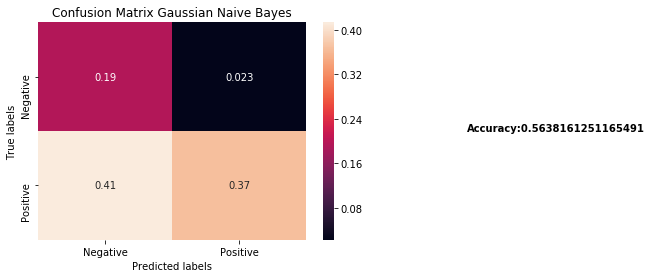

In [85]:
y_pred = Gaussian_NaiveB(X_train, y_train, X_test)
plot_conf_matrix(y_test, y_pred, model ='Gaussian Naive Bayes')

### Model 2 : RandomTree Forest


In [86]:
#Train and test the RandomForest model 
def RandomForest(X_train, y_train, X_test, rndm_state = 42, estimators = 200) : 
    """This function fits, train and runs the Gaussian Naive Bayes on the test set.
    It takes as argument arrays objects of the train feeatures and labels, and the test features, and a random state.
    It returns an array object of the predicted labels, y_pred."""
    model = ensemble.RandomForestClassifier(n_estimators=estimators, random_state=rndm_state)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred

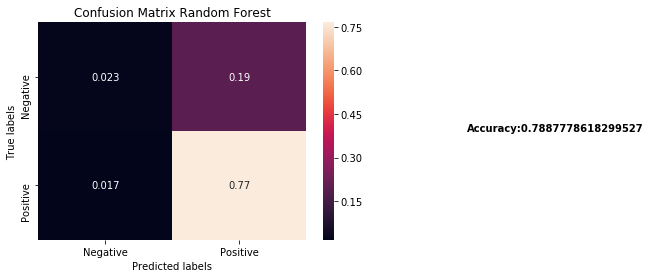

In [87]:
y_pred = RandomForest(X_train, y_train, X_test)
plot_conf_matrix(y_test, y_pred, model ='Random Forest')

### Model 3 : Multinomial Naive Bayes

In [88]:
#Train and test the Multinomial Naive Bayes model 
def MultinomialNB(X_train, y_train, X_test) :
    """This function fits, train and runs the Gaussian Naive Bayes on the test set.
    It takes as argument arrays objects of the train feeatures and labels, and the test features.
    It returns an array object of the predicted labels, y_pred."""
    model = naive_bayes.MultinomialNB()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [89]:
y_pred = MultinomialNB(X_train, y_train, X_test)

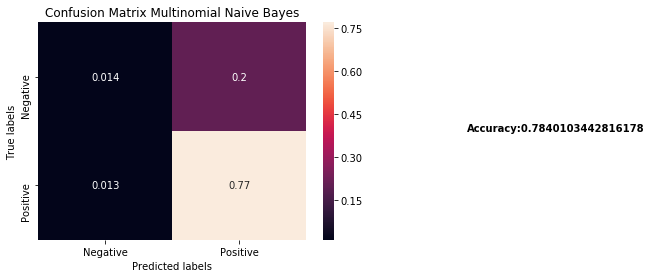

In [90]:
plot_conf_matrix(y_test, y_pred, model = 'Multinomial Naive Bayes')

## 4. Sentiment Analysis on full text of reviews
##### For this step, we will try to predict binary rating from the full reviews. 
#### 1. Vectorize text to analyze
#### 2. Split dataset
#### 3. Instantiate, train and test Model
#### 4. Plot confusion matrix

In [91]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
def instantiate_Tfidf(function) : 
    """This function instantiates the TfidfVectorizer.
    It takes as argument a text preprocessing function and returns a TfidfVectorizer Object."""
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=function,
                                 ngram_range=(1,3))
    return tfidf_vectorizer
tfidf = instantiate_Tfidf(tokenize_and_lem)


#Vectorize the text of the dataset using the TfidfVectorizer
def Tfidf_vectorize(tfidf_vectorizer, series):
    """This function vectorizes the text of the dataset using the TfidfVectorizer.
    It takes as argument a TfidfVectorizer object and Series object and returns an array object of vectors."""
    features = tfidf_vectorizer.fit_transform([x for x in series]).toarray()
    return features
features = Tfidf_vectorize(tfidf, file2['Text'])


#Split dataset in a training set and a testing set
def split_dataset(features, labels, rndm_state = 42) : 
    """This function splits the dataset into a train and a test dataset.
    It takes as argument the complete set of features (array) and labels (array) of the dataset, and a seed, and returns :
    X_train : train features - np array object
    X_test : test features - np array object
    y_train : train labels - np array object
    y_test : test labels - np array object"""

    X_train, X_test, y_train, y_test = model_selection.train_test_split(features, labels, test_size=0.2, random_state=rndm_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(features, file2['label'].values)


### Model 1 : GaussianNB 

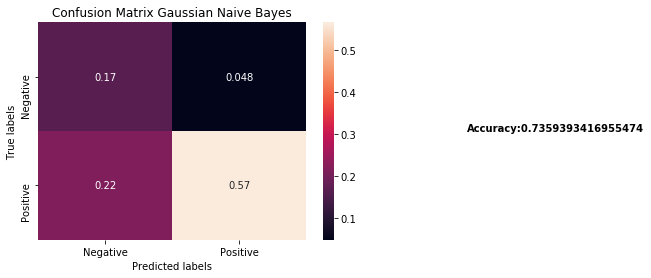

In [92]:
#Train and test the Gaussian models 

y_pred = Gaussian_NaiveB(X_train, y_train, X_test)
plot_conf_matrix(y_test, y_pred, model ='Gaussian Naive Bayes')

### Model 2 : RandomTree Forest

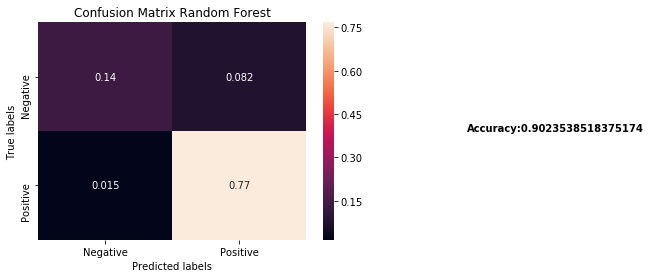

In [93]:
y_pred = RandomForest(X_train, y_train, X_test)
plot_conf_matrix(y_test, y_pred, model ='Random Forest')

### Model 3 : Multinomial Naive Bayes

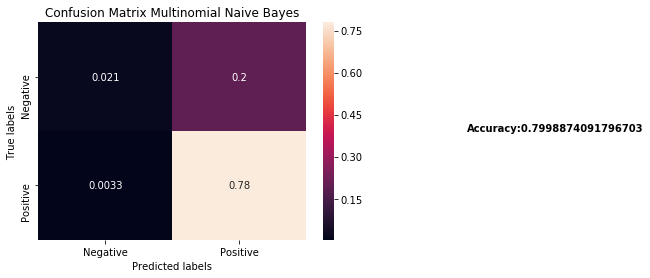

In [94]:
y_pred = MultinomialNB(X_train, y_train, X_test)
plot_conf_matrix(y_test, y_pred, model = 'Multinomial Naive Bayes')